# Traffic Sign Recognition Classifier by Abanoub David Awad
![LeNet Architecture](images/net_image.png)
Source: Yan LeCun

## Set up our dataset

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file  = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test   = test['features'], test['labels']

## No need for padding input traffic sign images
The LeNet architecture only accepts 32x32xC images, where C is the number of color channels. The traffic sign images are already 32x32 so we don't need to do any padding, and C is set to 3 for RGB images.

## Separating Traning data and Validation data

The traffic sign dataset doesn't come with a validation set, so we can separate out test data to do so. 


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 3)


## Step 1: Dataset Summary & Exploration

In [3]:
# Number of training examples
# took length of the pickled object's "labels" attr
n_train = 39209

# Number of testing examples.
# took length of the pickled object's "labels" attr
n_test = 12630

# What's the shape of an traffic sign image?
# (32 x 32 x 3)  32 by 32 pixel image with 3 color channels 
image_shape =  3072

# How many unique classes/labels there are in the dataset.
# based on the number of possible signs in signnames.csv
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 3072
Number of classes = 43


## Visualizing our Data

Let's look at a few samples from the dataset.

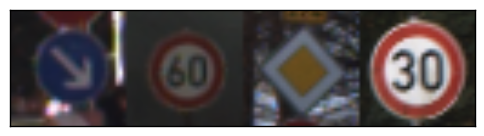

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


c = X_train[random.randint(0, len(X_train))].squeeze()

for i in range(3):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    c = np.concatenate((c, image), axis=1)

plt.tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')         
plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off') 


plt.imshow(c)

## Some information about the dataset

Here we've visualized how many of each type of sign we actually have to work with, based on this we can infer that we may not be able to get a very high accuracy of "Speed limit (20km/h)", "Dangerous curve to the right", and "Go straight or right" signs. They have the labels (0, 20, 36). 

We can do a little bit to fix this by jittering the images we already have in order to create more labeled examples to work with.

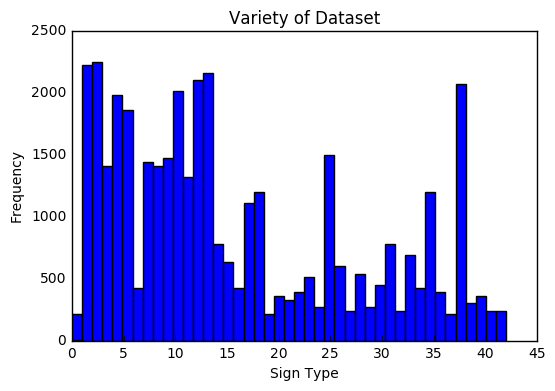

In [5]:
# Visualizations will be shown in the notebook.
%matplotlib inline

# number of traffic signs of each type
plt.hist(train['labels'], bins=43)
plt.title("Variety of Dataset")
plt.xlabel("Sign Type")
plt.ylabel("Frequency")
plt.tick_params(axis='x', which='both', top='off')         
plt.tick_params(axis='y', which='both', left='off', right='off')     

plt.show()

## Preprocess Data and Setup TensorFlow

Shuffle the training data.

The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [6]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

import tensorflow as tf

EPOCHS     = 30
BATCH_SIZE = 128

##  Step 2: Design and Test a Model Architecture 

We start out with the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture. 

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since the images are colored, C is 3 in this case.

### Output
Return the result of the 2nd fully connected layer.

In [7]:
from tensorflow.contrib.layers import flatten

# features and labels
# x is a placeholder for a batch of input images.
# y is a placeholder for a batch of output labels.

x         = tf.placeholder(tf.float32, (None, 32, 32, 3))
y         = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Hinton's dropout
keep_prob = tf.placeholder(tf.float32)

# TODO docs on the updated archtecture!! 

def LeNet(x):    
    # Hyperparameters weight initialization
    mu      = 0
    sigma   = 0.05
    
    # convolutional layer. Input = 32x32x3. Output = 28x28x6. Input depth for 3 color channels
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # activation.
    conv1   = tf.nn.relu(conv1)
    
    # apply dropout to activation
    conv1     = tf.nn.dropout(conv1, keep_prob)

    # pooling layer Input = 28x28x6. Output = 14x14x6.
    conv1   = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # convolutional layer. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # activation.
    conv2   = tf.nn.relu(conv2)
    
    # apply dropout to activation
    conv2     = tf.nn.dropout(conv2, keep_prob)
    
    # pooling layer Input = 10x10x16. Output = 5x5x16.
    conv2   = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # flatten. Input = 5x5x16. Output = 400.
    fc0     = flatten(conv2)
    
    # fully connected layer Input = 400. Output = 120.
    fc1_W   = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b   = tf.Variable(tf.zeros(120))
    fc1     = tf.matmul(fc0, fc1_W) + fc1_b
        
    # activation.
    fc1     = tf.nn.relu(fc1)

    # fully connected layer. Input = 120. Output = 84.
    fc2_W   = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b   = tf.Variable(tf.zeros(84))
    fc2     = tf.matmul(fc1, fc2_W) + fc2_b
    
    # activation.
    fc2     = tf.nn.relu(fc2)

    # cully connected layer Input = 84. Output = 43  (based on output classes in signames.csv)
    fc3_W   = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b   = tf.Variable(tf.zeros(43))
    logits  = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

## Training Pipeline

In [8]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.



In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # passing a keep_prob of 1 in order to evaluate the network
        
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.
Before each epoch, shuffle the training set.
After each epoch, measure the loss and accuracy of the validation set.
Save the model after training.


In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            # pass keep_prob of 0.5 for training the network
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print() # print newline
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.681

EPOCH 2 ...
Validation Accuracy = 0.854

EPOCH 3 ...
Validation Accuracy = 0.896

EPOCH 4 ...
Validation Accuracy = 0.924

EPOCH 5 ...
Validation Accuracy = 0.931

EPOCH 6 ...
Validation Accuracy = 0.938

EPOCH 7 ...
Validation Accuracy = 0.956

EPOCH 8 ...
Validation Accuracy = 0.946

EPOCH 9 ...
Validation Accuracy = 0.965

EPOCH 10 ...
Validation Accuracy = 0.953

EPOCH 11 ...
Validation Accuracy = 0.969

EPOCH 12 ...
Validation Accuracy = 0.962

EPOCH 13 ...
Validation Accuracy = 0.976

EPOCH 14 ...
Validation Accuracy = 0.979

EPOCH 15 ...
Validation Accuracy = 0.943

EPOCH 16 ...
Validation Accuracy = 0.968

EPOCH 17 ...
Validation Accuracy = 0.981

EPOCH 18 ...
Validation Accuracy = 0.977

EPOCH 19 ...
Validation Accuracy = 0.972

EPOCH 20 ...
Validation Accuracy = 0.977

EPOCH 21 ...
Validation Accuracy = 0.978

EPOCH 22 ...
Validation Accuracy = 0.973

EPOCH 23 ...
Validation Accuracy = 0.981

EPOCH 24 ...
Validation Accura

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.919


# Questions


## Question 1:
Describe how you preprocessed the data. Why did you choose that technique?
## Answer:
All that I've done in this notebook so far was to separate the test set into a test and validation set, just so that we can make sure to measure validation accuracy. 


With some more time; another thing we can do is to jitter some of the images that we have fewer samples of in order to get a more fair distribution of sign types. [Vivek Yadav has a great sample of what I'm talking about in another notebook here](https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb). 

## Question 2
Describe how you set up the training, validation and testing data for your model. Optional: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?
## Answer:

Training was set up in a straightforward jump from the MNIST example presented in the video, which gives us a great starting platform. Taking that advice, the training data was separated in the straightforward way into the training set and the validation set. 

We could also take the above approach of using opencv to just rotate and jitter the images in order to create additional samples, and if we were doing this, they would certainly be added to the training set and we would want to mostly generate signs that we don't have many samples of.

## Question 3
What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.) For reference on how to build a deep neural network using TensorFlow, see Deep Neural Network in TensorFlow from the classroom._
## Answer:

I wanted to use hinton's dropout and it turned out that using it was very effective and raised my validation accuracy up to 97% and brought my test accuracy up to 92%. 

### Final Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** ReLU activation.

**Regularization.** Hinton's Dropout.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** ReLU activation.

**Regularization.** Hinton's Dropout.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** ReLU activation.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** ReLU activation.

**Layer 5: Fully Connected (Logits).** This should have 43 outputs. This is becuase there are 43 different types of traffic signs in our dataset.



## Question 4
How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)
## Answer:

It took a long time to find a set of parameters that worked well, I was personally really surprised at how much of an impact the weight initialization could have on the outcome of training even after many epochs.

My final set of hyper paramters is the following:

    - Epochs: 30
    - Batch Size: 128
    - Mu: 0
    - Sigma: 0.05
    - Learning Rate: 0.05
    - Hinton Keep Probability: 0.5


The things that made the biggest changes were the number of epochs, as well as the Sigma value that created the largest differences for me when it came to training. 


## Question 5
What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem.
## Answer:

As far as coming up with solutions, I did a lot of digging online and through the forums about how others have built classifiers. The things most helpful for me really was taking the time to experiment with changing hyperparameters.

## Question 6
Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook.
## Answer:

The images that might give us the most trouble in general, are the ones that are the darkest. 

In general with darker images it becomes difficult to distinguish between different shades of colors, and I would bet that this is the case for computers as well.

There are also images without distinct features or significant blur that could definitely be tricky to classify for a human as well.

Another problem that could exist for some of the images is the distance the sign is from the camera which could cause more subtle details to be lost. This is something that cars might not be as worried about as they are usually moving towards the signs most relevant to them.

Below I've plotted some of the images that might cause us trouble as far as classification goes.

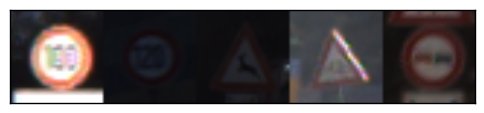

In [12]:
%matplotlib inline

c = X_train[21010].squeeze()

image = X_train[27574].squeeze()
c = np.concatenate((c, image), axis=1)

image = X_train[15549].squeeze()
c = np.concatenate((c, image), axis=1)

image = X_train[21149].squeeze()
c = np.concatenate((c, image), axis=1)

image = X_train[3502].squeeze()
c = np.concatenate((c, image), axis=1)


plt.tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')         
plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off') 

plt.imshow(c)

## Step 3: Test a Model on New Images
Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

###### You may find signnames.csv useful as it contains mappings from the class id (integer) to the actual sign name.


I spend some time digging around the internet for some good german traffic sign images and came across this on google images. 

![extra image](images/extra_images.png)

So I've picked apart a couple of samples that look like they could be in our dataset and we'll try classifying each of them.

| Speed limit (80km/h) | Turn right ahead | Speed limit (50km/h) | Speed limit (20km/h) | Dangerous curve to the right | Just for fun |
|---|---|---|---|---|---|
| 5 | 33 | 2 | 0 | 20 | ? (probably one of the km/h signs) |
| ![extra image](images/screenshot_1.png) | ![extra image](images/screenshot_2.png) | ![extra image](images/screenshot_3.png) | ![extra image](images/screenshot_4.png) | ![extra image](images/screenshot_5.png) | ![extra image](images/screenshot_6.png) |


We'll need a couple of tricks to resize our images in order for them to be used in our classifier, using numpy and some functions from scipy we can resize images to our preference with relative ease. 


Test Accuracy = 0.333


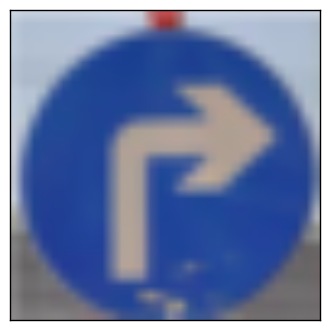

In [13]:
%matplotlib inline
import scipy
from scipy import ndimage
from scipy.misc import imresize


extra_labels = np.array([5, 33, 2, 0, 20, 4])
extra_images = [] 

# iterate through the saved screenshots
for i in range(1,7):
    sc = 'images/screenshot_'+str(i)+'.png'
    temp_image = scipy.ndimage.imread(sc)
    
    sample = imresize(temp_image,(32, 32))
    sample = np.delete(sample, 3, 2)
    
    extra_images.append(sample)

extra_test   = np.array(extra_images)
extra_labels = extra_labels.astype(np.uint8, copy=False)    
    
plt.tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')         
plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off') 


plt.imshow(extra_images[1])

labels       = np.array([5, 33, 2, 0, 20, 4])
extra_test   = np.array(extra_images)
extra_labels = labels.astype(np.uint8, copy=False)


## run our trained network on this miniature set
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(extra_test, extra_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Surprisingly, we did not correctly classify the American stop sign.

## Question 7
Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate.

###### NOTE: You could check the accuracy manually by using signnames.csv (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in signnames.csv and see if it matches the sign from the image.
## Answer:

Not counting the stop sign, our performance is essentially 20% on this small sampling of images, which is in huge contrast to our ~90% accuracy on the test set.

Notice that we correctly classify only one of these 5 images; which is a surprise but perhaps this particular set of images isn't constructive.


## Question 8
Use the model's softmax probabilities to visualize the certainty of its predictions, tf.nn.top_k could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)
tf.nn.top_k will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.
Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
Running it through sess.run(tf.nn.top_k(tf.constant(a), k=3)) produces:
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```
Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.


## Answer:
We can look at one of our new photos and see how they're interpreted by our neural network. 

We start by feeding our properly re-sized images into the neural network, while making sure to record the top `k` values that were passed as our probabilities. 

In [14]:
%matplotlib inline


init_op      = tf.global_variables_initializer()
logits       = LeNet(x)
prediction   = tf.nn.softmax(logits)
top_k        = tf.nn.top_k(prediction, k=5, sorted=True, name=None)


## run our trained network on this miniature set
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(init_op)

    top_k_probabilities_per_image = sess.run(top_k, feed_dict={x: extra_test, y: extra_labels, keep_prob:1})

    values = np.array([top_k_probabilities_per_image.values])
    indices = np.array([top_k_probabilities_per_image.indices])

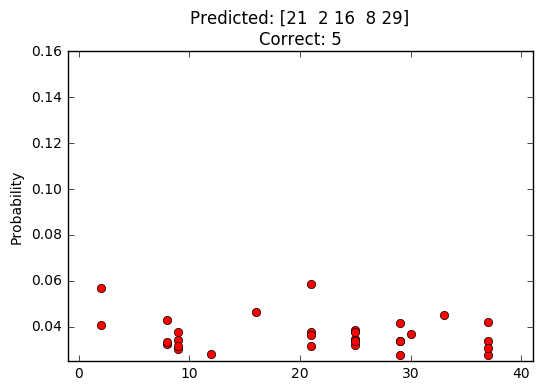

In [15]:
def plot_top_k_probabilities(pred_cls, pred_prob, title):
    plt.plot(list(pred_cls), list(pred_prob), 'ro')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1-1,x2+1,y1,y2+0.1))

    plt.ylabel('Probability')
    plt.title(title)
    plt.show()


predicted_class = indices[0][np.argmax(values[0])]    

correct_class = extra_labels[0]

plot_title = 'Predicted: {}\nCorrect: {}'.format(predicted_class, correct_class) 
    
plot_top_k_probabilities(indices[0], values[0], plot_title)

When we graph out the precitions by our network we can see where the highest softmax probability lies, and thus what our network is the most sure about.

## Potential Improvements
I would love to try other improvements suggested in the deep learning module such as l2 regularization. 

I also think this training is a good example of when we would want to stop training when our accuracy gets too high. 

In this run, we hit a validation accuracy of 98.2% which looks pretty good, and that's barring the improvements we can make to this network.


Ultimately, our network generalizes pretty well, with a final accuracy of 91.9%.


# Thank you to the project mentors and reviewers! 